In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

In [4]:
true_df = pd.read_csv(r"/content/True.csv")
fake_df = pd.read_csv(r"/content/Fake.csv")

In [5]:
true_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [6]:
fake_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [7]:
true_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [8]:
fake_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [9]:
print("True dataset shape:", true_df.shape)
print("Fake dataset shape:", fake_df.shape)

True dataset shape: (21417, 4)
Fake dataset shape: (23481, 4)


In [10]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
true_df["label"] = 1
fake_df["label"] = 0

In [12]:
df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)

In [13]:
print(df.shape)

(44898, 5)


In [14]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


/tmp/ipython-input-930643103.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


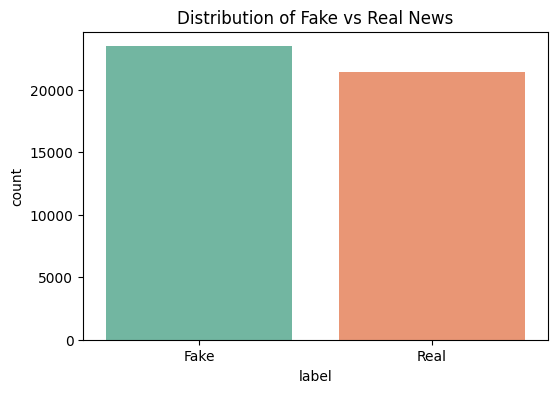

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, palette="Set2")
plt.xticks([0,1], ["Fake", "Real"])
plt.title("Distribution of Fake vs Real News")
plt.show()

In [16]:
df["content"] = df["title"] + " " + df["text"]

df = df[["content", "label"]]

In [17]:
df.head()

,content,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [18]:
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["content"], df["label"], test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print("Train size:", len(train_texts))
print("Validation size:", len(val_texts))
print("Test size:", len(test_texts))

Train size: 31428
Validation size: 6735
Test size: 6735


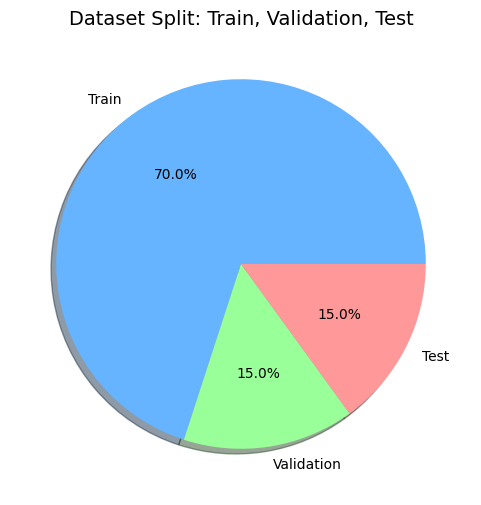

In [19]:
train_size = len(train_texts)
val_size = len(val_texts)
test_size = len(test_texts)

sizes = [train_size, val_size, test_size]
labels = ['Train', 'Validation', 'Test']
colors = ['#66b3ff', '#99ff99', '#ff9999']

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    shadow=True
)
plt.title('Dataset Split: Train, Validation, Test', fontsize=14)
plt.show()


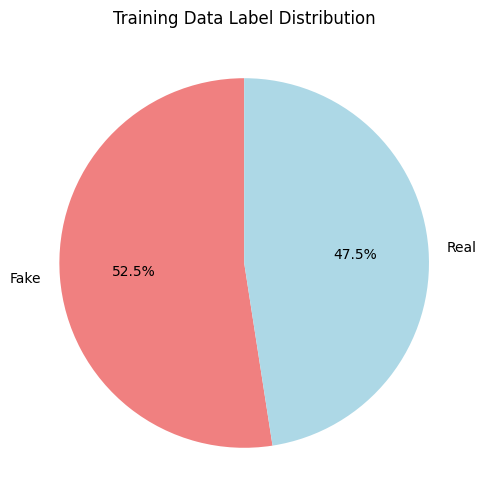

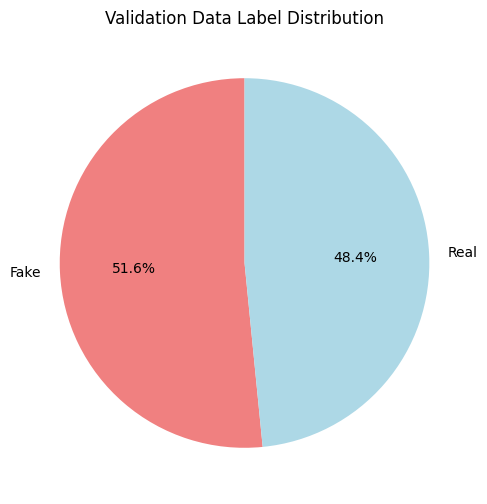

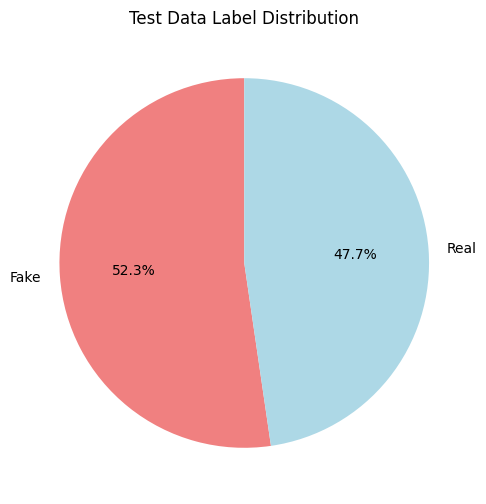

In [20]:
def plot_pie_distribution(texts, labels, dataset_name):
    df = pd.DataFrame({"content": texts, "label": labels})
    label_counts = df['label'].value_counts()

    plt.figure(figsize=(6,6))
    plt.pie(
        label_counts.values,
        labels=['Fake', 'Real'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightcoral', 'lightblue']
    )
    plt.title(f"{dataset_name} Data Label Distribution")
    plt.show()

plot_pie_distribution(train_texts, train_labels, "Training")
plot_pie_distribution(val_texts, val_labels, "Validation")
plot_pie_distribution(test_texts, test_labels, "Test")


In [21]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(train_texts),
                            truncation=True,
                            padding=True,
                            max_length=256)

val_encodings = tokenizer(list(val_texts),
                          truncation=True,
                          padding=True,
                          max_length=256)

test_encodings = tokenizer(list(test_texts),
                           truncation=True,
                           padding=True,
                           max_length=256)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [23]:
import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = NewsDataset(train_encodings, list(train_labels))
val_dataset = NewsDataset(val_encodings, list(val_labels))
test_dataset = NewsDataset(test_encodings, list(test_labels))


In [24]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="steps",
    save_steps=500,
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2799919986.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.031600
1000,0.006900
1500,0.004400
2000,0.002700
2500,0.001500
3000,0.001400
3500,0.001800


TrainOutput(global_step=3930, training_loss=0.006403312052223291, metrics={'train_runtime': 2989.1003, 'train_samples_per_second': 21.028, 'train_steps_per_second': 1.315, 'total_flos': 8269054247854080.0, 'train_loss': 0.006403312052223291, 'epoch': 2.0})

In [32]:
import os

# Define the path (for Google Colab, this saves inside /content/Downloads)
save_directory = os.path.expanduser("~/Downloads/fake_news_model")

# Create directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"✅ Model and tokenizer saved successfully at: {save_directory}")


✅ Model and tokenizer saved successfully at: /root/Downloads/fake_news_model


In [33]:
model.save_pretrained("/content/fake_news_BERT_model")
tokenizer.save_pretrained("/content/fake_news_BERT_model")


('/content/fake_news_BERT_model/tokenizer_config.json',
 '/content/fake_news_BERT_model/special_tokens_map.json',
 '/content/fake_news_BERT_model/vocab.txt',
 '/content/fake_news_BERT_model/added_tokens.json')

In [34]:
!zip -r /content/fake_news_BERT_model.zip /content/fake_news_BERT_model


  adding: content/fake_news_BERT_model/ (stored 0%)
  adding: content/fake_news_BERT_model/config.json (deflated 49%)
  adding: content/fake_news_BERT_model/vocab.txt (deflated 53%)
  adding: content/fake_news_BERT_model/model.safetensors (deflated 7%)
  adding: content/fake_news_BERT_model/tokenizer_config.json (deflated 75%)
  adding: content/fake_news_BERT_model/special_tokens_map.json (deflated 42%)


In [35]:
from google.colab import files
files.download("/content/fake_news_BERT_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>